# Porto Seguro’s Safe Driver Prediction


<br><font color=blue>The aim of this compitation is to predict probability that a driver will intiate an auto insurance claim next year.A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers. </font>


# Import library

In [1]:
#Import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV,GridSearchCV
import xgboost as xgb
import lightgbm as lgb
seed =45
% matplotlib inline

/home/sudhir/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read data set

In [2]:
#path = '../input/'
path = ''
train = pd.read_csv(path+'train.csv',na_values=-1)
test = pd.read_csv(path+'test.csv',na_values=-1)
print('Number rows and columns:',train.shape)
print('Number rows and columns:',test.shape)

Number rows and columns: (595212, 59)
Number rows and columns: (892816, 58)


## Explore data set

In [3]:
train.head(3).T

,0,1,2
id,7.000000,9.000000,13.000000
target,0.000000,0.000000,0.000000
ps_ind_01,2.000000,1.000000,5.000000
ps_ind_02_cat,2.000000,1.000000,4.000000
ps_ind_03,5.000000,7.000000,9.000000
ps_ind_04_cat,1.000000,0.000000,1.000000
ps_ind_05_cat,0.000000,0.000000,0.000000
ps_ind_06_bin,0.000000,0.000000,0.000000
ps_ind_07_bin,1.000000,0.000000,0.000000
ps_ind_08_bin,0.000000,1.000000,1.000000


## Target varaiable

0    573518
1     21694
Name: target, dtype: int64

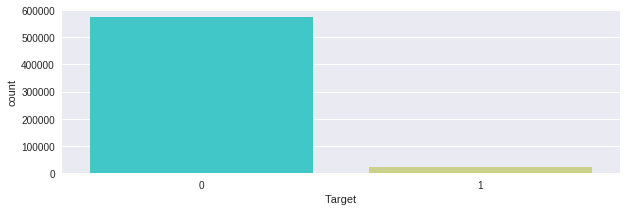

In [4]:
plt.figure(figsize=(10,3))
sns.countplot(train['target'],palette='rainbow')
plt.xlabel('Target')

train['target'].value_counts()

The 'target' variable in imbalanced 

# CORELATION PLOT

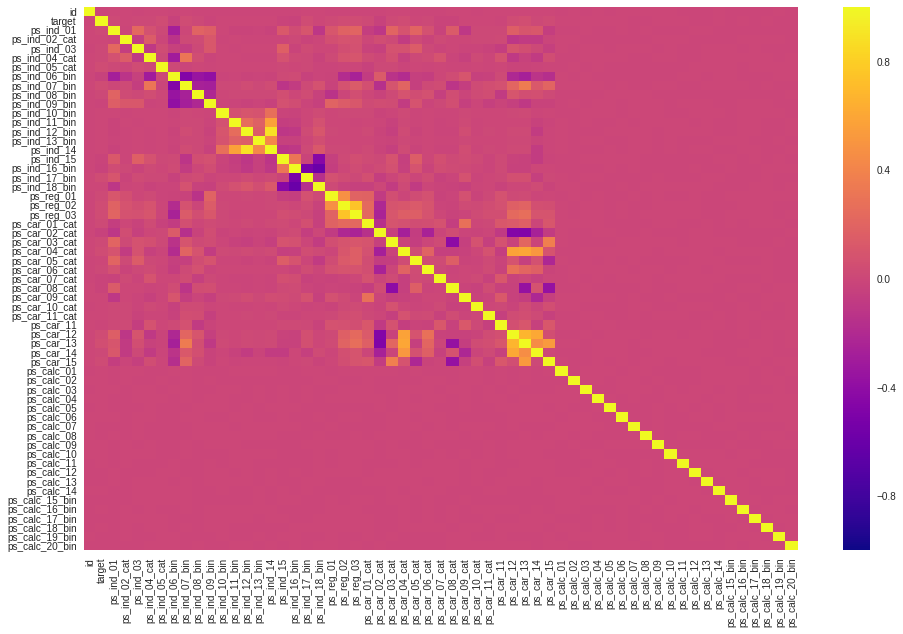

In [9]:
cor = train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor,cmap='plasma');

###  ps calc  *  value as 0 relation with remaining varialble

In [10]:
ps_cal = train.columns[train.columns.str.startswith('ps_calc')] 
train = train.drop(ps_cal,axis =1)
test = test.drop(ps_cal,axis=1)
train.shape

(595212, 39)

In [11]:
train['target'] = train['target'].astype('category')

# Missing value is data set

"""Values of -1 indicate that the feature was missing from the observation. 
The target columns signifies whether or not a claim was filed for that policy holder.""

In [12]:
k= pd.DataFrame()
k['train']= train.isnull().sum()
k['test'] = test.isnull().sum()
k

,train,test
id,0,0.0
target,0,NaN
ps_ind_01,0,0.0
ps_ind_02_cat,216,307.0
ps_ind_03,0,0.0
ps_ind_04_cat,83,145.0
ps_ind_05_cat,5809,8710.0
ps_ind_06_bin,0,0.0
ps_ind_07_bin,0,0.0
ps_ind_08_bin,0,0.0


Missing value in test train data set are in same propotion and same column

In [13]:
def missing_value(df):
    col = df.columns
    for i in col:
        if df[i].isnull().sum()>0:
            df[i].fillna(df[i].mode()[0],inplace=True)

In [14]:
missing_value(train)
missing_value(test)

# Univariate analysis

In [15]:
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['int']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

In [16]:
def change_datatype_float(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)

In [7]:
cat_col = [col for col in train.columns if '_cat' in col]
print(cat_col)

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']


In [8]:
for c in cat_col:
    train[c] = train[c].astype('uint8')
    test[c] = test[c].astype('uint8') 

In [9]:
bin_col = [col for col in train.columns if 'bin' in col]
print(bin_col)

['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin']


All the columns ends with cat can be converted into dtype uint8

In [10]:
for c in bin_col:
    train[c] = train[c].astype('uint8')
    test[c] = test[c].astype('uint8') 

In [11]:
def category_col(df):
    c_col = df.columns
    to_cat_col =[]
    for i in c_col:
        if df[i].nunique()<=104:
            to_cat_col.append(i)
    return to_cat_col


tot_cat_col = category_col(train)
other_cat_col = [c for c in tot_cat_col if c not in cat_col+ bin_col]
other_cat_col

['target',
 'ps_ind_01',
 'ps_ind_03',
 'ps_ind_14',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_car_11',
 'ps_car_15']

In [12]:
ot_col = ['ps_ind_01','ps_ind_03','ps_ind_14','ps_ind_15','ps_car_11']
for c in ot_col:
    train[c] = train[c].astype('uint8')
    test[c] = test[c].astype('uint8') 

In [13]:
num_col = [c for c in train.columns if c not in tot_cat_col]
#num_col.append('ps_car_15')
#train['ps_car_15'] = train['ps_car_15'].astype('float32')
#test['ps_car_15'] = test['ps_car_15'].astype('float32')
num_col.remove('id')
num_col

['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14']

# Determine outliers in dataset

In [14]:
def outlier(df,columns):
    for i in columns:
        quartile_1,quartile_3 = np.percentile(df[i],[25,75])
        quartile_f,quartile_l = np.percentile(df[i],[1,99])
        IQR = quartile_3-quartile_1
        lower_bound = quartile_1 - (1.5*IQR)
        upper_bound = quartile_3 + (1.5*IQR)
        print(i,lower_bound,upper_bound,quartile_f,quartile_l)
        
        df[i].loc[df[i] < lower_bound] = quartile_f
        df[i].loc[df[i] > upper_bound] = quartile_l
        
num_col = ['ps_reg_03', 'ps_car_13', 'ps_car_14']
outlier(train,num_col)
outlier(test,num_col)

ps_reg_03 0.08484029175 1.54909582495 0.4183300133 1.8521946442


/home/sudhir/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


ps_car_13 0.31788087655 1.25917611615 0.448300509774 1.61761689551
ps_car_14 0.2891566485 0.4608812941 0.2887905816 0.5234500931
ps_reg_03 0.08156262285 1.55455860645 0.4190763654 1.8521946442
ps_car_13 0.318887063862 1.25847823656 0.4485283558 1.61723992314
ps_car_14 0.2891566485 0.4608812941 0.2887905816 0.5234500931


# Split data set

In [15]:
X = train.drop(['target','id'],axis=1)
y = train['target'].astype('category')
x_test = test.drop('id',axis=1)

# Hyper parameter tuning

In [16]:
xg_cl = xgb.XGBClassifier(max_depth=4,learning_rate=0.1,n_estimators=5300,objective='binary:logistic',
                          min_child_weight=1,scale_pos_weight=1)
param = {'max_depth':[3,4,5,7,10],
         'learning_rate':[0.01,0.03,0.07,0.1,0.3,0.5],
         'min_child_weight':[1,3,5,7,10],
         'reg_lambda':[0.1,0.5,1,1.3,1.7,2.5],
         'reg_alpha':[1,1.5,3,8,10,12,15],
         'gamma':[0.1,0.5,1,2,5,10],
         'subsample':[0.4,0.5,0.6,0.7,0.8,0.9,1],
        'colsample_bytree':[0.4,0.5,0.6,0.7,0.8,0.9,1],
         'scale_pos_weight':[0.5,1,2,3,5,10]}
clf = GridSearchCV(xg_cl,param,scoring='roc_auc',refit=True,cv=10)

clf.fit(X,y)
print('Best roc_auc: {:.4}, with best params: {}'.format(clf.best_score_, clf.best_params_))


KeyboardInterrupt: 

# XGBoost

In [36]:
def runXGB(xtrain,xvalid,ytrain,yvalid,xtest,eta=0.07,num_rounds=100,max_depth=3):
    params = {
        'objective':'binary:logistic',        
        'max_depth':max_depth,
        'learning_rate':eta,
        'eval_metric':'auc',
        'min_child_weight':6,
        'subsample':0.8,
        'colsample_bytree':0.8,
        'seed':seed,
        'reg_lambda':1.3,
        'reg_alpha':8,
        'gamma':10,
        'scale_pos_weight':1.6
        #'n_thread':-1
    }
    
    dtrain = xgb.DMatrix(xtrain,label=ytrain)
    dvalid = xgb.DMatrix(xvalid,label=yvalid)
    dtest = xgb.DMatrix(xtest)
    watchlist = [(dtrain,'train'),(dvalid,'test')]
    
    model = xgb.train(params,dtrain,num_rounds,watchlist,early_stopping_rounds=50,verbose_eval=50)
    pred = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    pred_test = model.predict(dtest,ntree_limit=model.best_ntree_limit)
    return pred_test,model
    

In [37]:
kf = StratifiedKFold(n_splits=10,random_state=seed,shuffle=True)
pred_test_full =0
cv_score = []
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    pred_test,xg_model = runXGB(xtr,xvl,ytr,yvl,x_test,num_rounds=1000,eta=0.1)    
    pred_test_full += pred_test
    cv_score.append(xg_model.best_score)
    i+=1

1 of KFold 10
[0]	train-auc:0.578413	test-auc:0.579901
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.634819	test-auc:0.624551
[100]	train-auc:0.645504	test-auc:0.632057
[150]	train-auc:0.650145	test-auc:0.633725
[200]	train-auc:0.652436	test-auc:0.63459
[250]	train-auc:0.653772	test-auc:0.634604
[300]	train-auc:0.655515	test-auc:0.634722
Stopping. Best iteration:
[277]	train-auc:0.654853	test-auc:0.635026

2 of KFold 10
[0]	train-auc:0.58403	test-auc:0.591596
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.634302	test-auc:0.631272
[100]	train-auc:0.645199	test-auc:0.639148
[150]	train-auc:0.650027	test-auc:0.641125
[200]	train-auc:0.652002	test-auc:0.641618
[250]	train-auc:0.654001	test-auc:0.642054
[300]	train-auc:0.655449	test-auc:0.642077
[350]	train-auc:0.656778	t

# Model accuracy

In [38]:
print(cv_score)
print('Mean cv_score',np.mean(cv_score))

[0.635026, 0.642517, 0.633254, 0.650329, 0.640683, 0.64901, 0.629519, 0.648212, 0.647207, 0.642058]
Mean cv_score 0.6417815


In [39]:
pred_xgb = pred_test_full/10

# Important Features

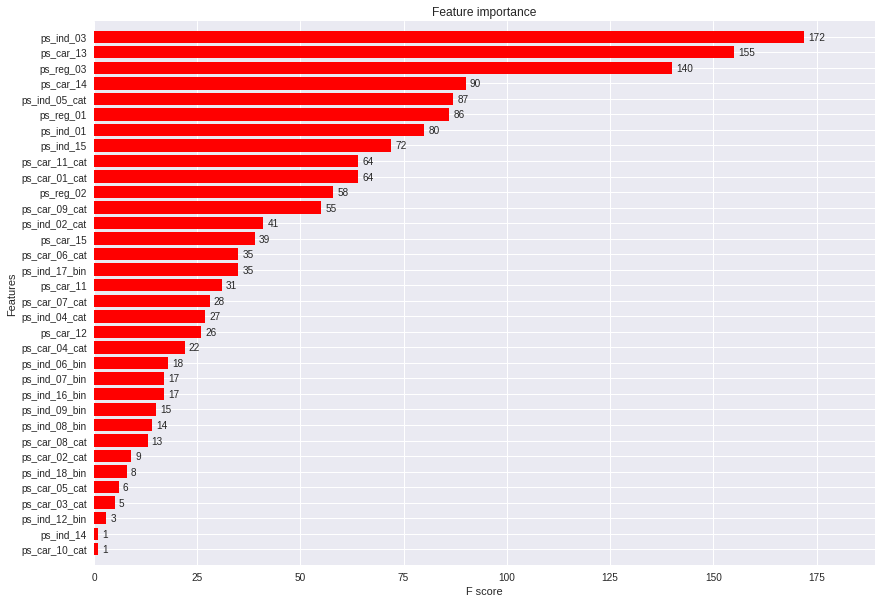

In [40]:
fig,ax = plt.subplots(figsize=(14,10))
xgb.plot_importance(xg_model,ax=ax,height=0.8,color='r')
#plt.tight_layout()
plt.show()

# Predict for unsen data set

In [41]:
y_pred = pred_xgb
submit = pd.DataFrame({'id':test['id'],'target':y_pred})
#submit.to_csv('xgb_porto.csv',index=False)
submit.to_csv('xgb_porto.csv.gz',index=False,compression='gzip') 

# Light GBM

In [26]:
def runLGB(train,valid,y_train,y_valid,test,eta=0.5,num_rounds=10,early_stop=50,max_depth=10):
    
    param = {
            'objective':'binary',
            'boosting':'gbdt',
            'learning_rate':eta,            
            'metric':'auc',
            'bagging_fraction':0.8,
            #'bagging_freq':5,
            'bagging_seed':seed,
            'num_leaves':100,
            'feature_fraction':0.8,
            #'verbose':10,            
            'min_child_weight':10,
            'max_depth':max_depth,
            'reg_alpha':1.5, 
            'reg_lambda':5,
            'scale_pos_weight':5       
            #'nthread':-1           
            }
   
    lgtrain = lgb.Dataset(train,label=y_train)
    lgvalid = lgb.Dataset(valid,label=y_valid)
    
    model=lgb.train(param,lgtrain,num_rounds,valid_sets=lgvalid,
              early_stopping_rounds=early_stop,verbose_eval=50 )
    #lg_pred = model.predict(xvl,num_iteration=model.best_iteration)
    pred = model.predict(test,num_iteration=model.best_iteration)    
    return pred,model

In [27]:
#Kfold
kf = StratifiedKFold(n_splits =5,random_state=seed,shuffle=True)
pred_test_full=0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index], X.loc[test_index]    
    ytr,yvl = y[train_index], y[test_index]
    
    pred_test,lg_model = runLGB(xtr,xvl,ytr,yvl,x_test,eta=0.1,num_rounds=1000,max_depth=7)
    pred_test_full +=pred_test
    cv_score.append(lg_model.best_score)
    i+=1

1 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.637261
[100]	valid_0's auc: 0.635718
Early stopping, best iteration is:
[65]	valid_0's auc: 0.637864
2 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.637016
[100]	valid_0's auc: 0.636998
Early stopping, best iteration is:
[83]	valid_0's auc: 0.637397
3 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.644203
Early stopping, best iteration is:
[47]	valid_0's auc: 0.644413
4 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.634972
[100]	valid_0's auc: 0.634182
Early stopping, best iteration is:
[74]	valid_0's auc: 0.635912
5 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.641022
[100]	valid_0's auc: 0.638666
Early stopping, best iteration is:
[51]	valid_0's auc: 0.641395


In [28]:
pred_lgb = pred_test_full/5

# Important Features

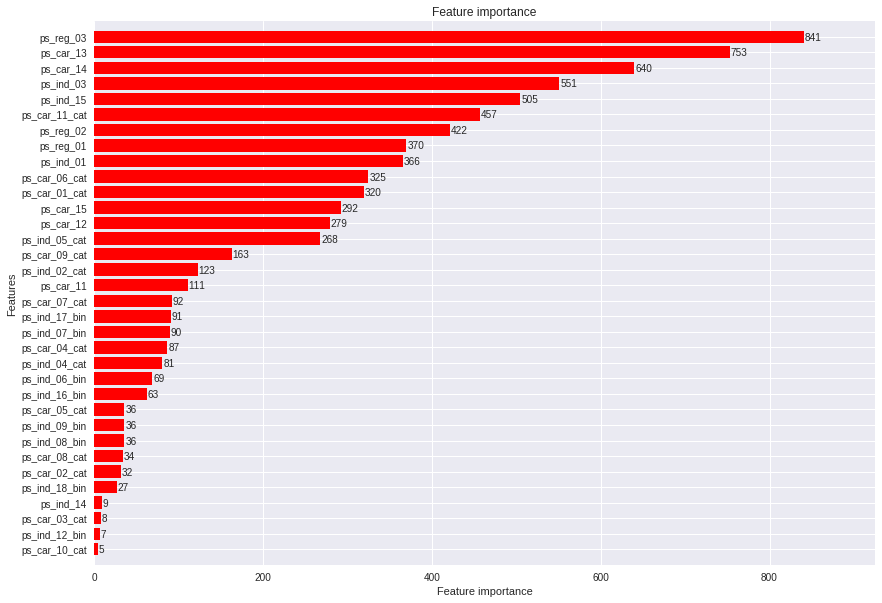

In [28]:
fig,ax = plt.subplots(figsize=(14,10))
lgb.plot_importance(lg_model,ax=ax,height=0.8,color='r')
#plt.tight_layout()
plt.show()

In [31]:
y_pred = pred_lgb*0.5+pred_xgb*0.5
submit = pd.DataFrame({'id':test['id'],'target':y_pred})
#submit.to_csv('xglg_porto.csv',index=False)
submit.to_csv('lr_porto.csv.gz',index=False,compression='gzip') 

# Thank you for visiting